In [1]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
import os
import gc

from scipy.sparse.linalg import eigsh, eigs
import torch.nn.functional as F
from pymatting.util.util import row_sum
from scipy.sparse import diags

In [2]:
# from torch.nn import Linear, GELU

In [3]:
# def flush():
#     gc.collect()
#     torch.cuda.empty_cache()

In [4]:
# del model
# flush()

In [5]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
}

In [6]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  0#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  0#@param {type:"number"}

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
# model, preprocess = clip.load("RN50", device=device, jit=False)

In [10]:
def get_fev (feats):
    # feats = F.normalize(final_visual_feats.detach().clone().squeeze().cpu(), p = 2, dim = -1)
                    # else:
                        # feats = F.normalize(feats_list[i].detach().clone().squeeze().cpu(), p = 2, dim = -1)[1:-1]

                    # print(f"Features' shape: {feats.shape}")
                    # skew_vec = []
    # image_feats = image_feats.type(torch.float32).cpu()
    # lang_feats = lang_feats.type(torch.float32).cpu()
    # feats = F.normalize(feats.detach(), p = 2, dim = -1)
    feats = feats.type(torch.float32)


    # print(feats.shape)
    # W_feat = feats
    W_feat = (feats @ feats.T)
    W_feat = (W_feat * (W_feat > 0))
    W_feat = W_feat / W_feat.max() 

    W_feat = W_feat.detach().cpu().numpy()


    def get_diagonal (W):
        D = row_sum(W)
        D[D < 1e-12] = 1.0  # Prevent division by zero.
        D = diags(D)
        return D

    D = np.array(get_diagonal(W_feat).todense())

    L = D - W_feat


    try:
        eigenvalues, eigenvectors = eigs(L, k = 5, which = 'LM', sigma = -0.5, M = D)
    except:
        try:
            eigenvalues, eigenvectors = eigs(L, k = 5, which = 'LM', sigma = 0)
        except:
            eigenvalues, eigenvectors = eigs(L, k = 5, which = 'SM')



    eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
    n_tuple = torch.kthvalue(eigenvalues.real, 2)
                # print(f"N_Tuple: {n_tuple.indices}")
    fev_idx = n_tuple.indices

    fev = eigenvectors[fev_idx]
    return torch.abs(fev)

In [12]:
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

In [40]:

def interpret_with_fev(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1

    cams = []
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach().unsqueeze(0)[:, :, 1:, 1:]
        cam = get_fev(blk.feats[1:, 0, :])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        grad = grad.clamp(min=0).mean(dim=0)
        cam = cam.unsqueeze(1)
        cam = cam.to(device)
        cam = grad * cam

        cams.append(cam[:, 0])

    image_relevance = torch.stack(cams, dim=0).sum(dim=0)
    # print(image_relevance)

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())
    cams1 = []
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        # print(f"texttttttt: {blk.feats.size()}")
        cam = get_fev(blk.feats[:, 0, :])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        grad = grad.clamp(min=0).mean(dim=0)
        cam = cam.unsqueeze(1)
        # print(f"cam shape: {cam.size()}")
        cam = cam.to(device)
        cam = grad * cam
   
        # print(f"TEXT REL SHAPE: {cam.size()}")
        cams1.append(cam)
    text_relevance = torch.stack(cams1, dim=0).sum(dim=0)

    return image_relevance, text_relevance

In [41]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image)
    axs[0].set_title("Original")
    axs[0].axis('off')

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis)
    axs[1].set_title("Heatmap (DSM + Grad)")
    axs[1].axis('off')

In [42]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  # print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

logits image shape: torch.Size([1, 1])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an astronaut and a rocket


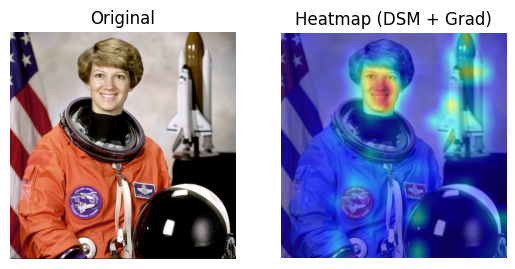

In [48]:
image_path = "CLIP/astronaut.png"
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
texts = ["an astronaut and a rocket"]
text = clip.tokenize(texts).to(device)
image_relevance, text_relevance = interpret_with_fev(model=model, image=image, texts=text, device=device)
# print(f"TEXT RELEVANCE SHAPE: {text_relevance.size()}")
show_heatmap_on_text(texts[0], text[0], text_relevance)
show_image_relevance(image_relevance, image, orig_image=Image.open(image_path))